In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.tight_layout()
dataset = pd.read_parquet("../data/dataset_depth8_Sam_Raph_Sothatsit5.parquet")

<Figure size 640x480 with 0 Axes>

array([[<AxesSubplot: title={'center': 'roll'}>,
        <AxesSubplot: title={'center': 'x'}>,
        <AxesSubplot: title={'center': 'y'}>,
        <AxesSubplot: title={'center': 'light_turn'}>,
        <AxesSubplot: title={'center': 'utility'}>],
       [<AxesSubplot: title={'center': 'light_score'}>,
        <AxesSubplot: title={'center': 'dark_score'}>,
        <AxesSubplot: title={'center': 'light_left'}>,
        <AxesSubplot: title={'center': 'dark_left'}>,
        <AxesSubplot: title={'center': 'rank'}>],
       [<AxesSubplot: title={'center': 'game0'}>,
        <AxesSubplot: title={'center': 'game1'}>,
        <AxesSubplot: title={'center': 'game2'}>,
        <AxesSubplot: title={'center': 'game3'}>,
        <AxesSubplot: title={'center': 'game4'}>],
       [<AxesSubplot: title={'center': 'game5'}>,
        <AxesSubplot: title={'center': 'game6'}>,
        <AxesSubplot: title={'center': 'game7'}>,
        <AxesSubplot: title={'center': 'game8'}>,
        <AxesSubplot: title={'

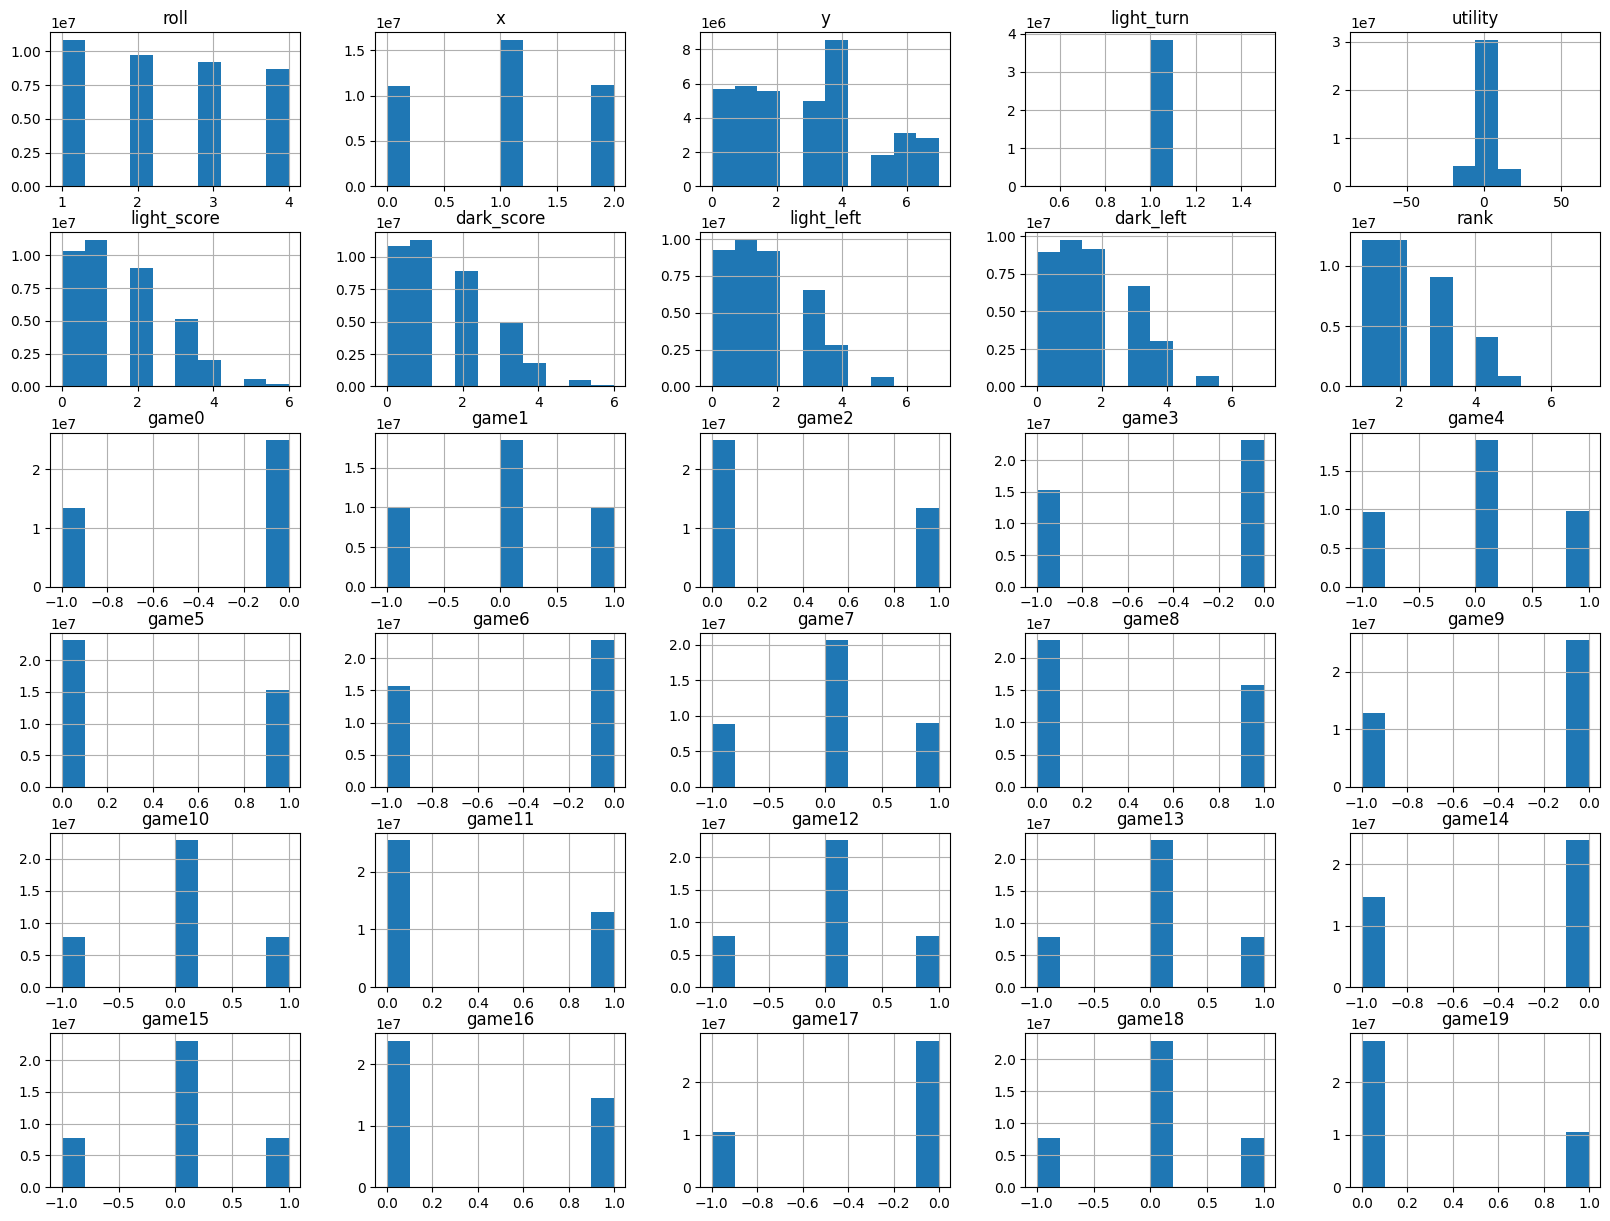

In [2]:
dataset.astype({'light_turn': 'int32'}).hist(figsize=(20, 15))

In [3]:
pd.set_option('display.max_columns', None)
dataset.astype({'light_turn': 'int32'}).describe()

,roll,x,y,light_turn,utility,light_score,dark_score,light_left,dark_left,rank,game0,game1,game2,game3,game4,game5,game6,game7,game8,game9,game10,game11,game12,game13,game14,game15,game16,game17,game18,game19
count,3.843231e+07,3.843231e+07,3.843231e+07,38432314.0,3.843231e+07,3.843231e+07,3.843231e+07,3.843231e+07,3.843231e+07,3.843231e+07,3.843231e+07,3.843231e+07,3.843231e+07,3.843231e+07,3.843231e+07,3.843231e+07,3.843231e+07,3.843231e+07,3.843231e+07,3.843231e+07,3.843231e+07,3.843231e+07,3.843231e+07,3.843231e+07,3.843231e+07,3.843231e+07,3.843231e+07,3.843231e+07,3.843231e+07,3.843231e+07
mean,2.406717e+00,1.000855e+00,2.963402e+00,1.0,1.203246e+00,1.472880e+00,1.422612e+00,1.629013e+00,1.674568e+00,2.210103e+00,-3.490823e-01,-1.743325e-06,3.500776e-01,-3.970984e-01,1.514481e-03,3.974741e-01,-4.064678e-01,1.047686e-03,4.090099e-01,-3.360249e-01,1.602662e-03,3.376745e-01,-4.200111e-04,-1.017347e-03,-3.795124e-01,5.222168e-05,3.785472e-01,-2.741123e-01,-7.535586e-04,2.722035e-01
std,1.120927e+00,7.610023e-01,2.098224e+00,0.0,6.342278e+00,1.278273e+00,1.261796e+00,1.309414e+00,1.330007e+00,1.080866e+00,4.766800e-01,7.201867e-01,4.769940e-01,4.892967e-01,7.110901e-01,4.893756e-01,4.911738e-01,6.807694e-01,4.916511e-01,4.723475e-01,6.362261e-01,4.729170e-01,6.421011e-01,6.368960e-01,4.852657e-01,6.326186e-01,4.850250e-01,4.460658e-01,6.347822e-01,4.450941e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.0,-7.888239e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,1.000000e+00,1.0,-2.723443e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,1.000000e+00,3.000000e+00,1.0,1.034908e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.000000e+00,2.000000e+00,4.000000e+00,1.0,5.201734e+00,2.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,4.000000e+00,2.000000e+00,7.000000e+00,1.0,6.794952e+01,6.000000e+00,6.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00


In [4]:
pd.set_option('display.max_columns', None)
dataset.sample(n=10)

,game,roll,x,y,light_turn,utility,light_score,dark_score,light_left,dark_left,rank,game0,game1,game2,game3,game4,game5,game6,game7,game8,game9,game10,game11,game12,game13,game14,game15,game16,game17,game18,game19
49343409,--D --- LL- --D .L. .D. L-- --D,4,1,2,True,-0.305655,2,2,1,1,3,0,0,1,0,0,0,-1,-1,0,0,0,1,-1,1,-1,0,0,0,0,1
57224794,-D- L-D LD- L-- .-. .-. L-D -L-,4,1,0,True,-0.369847,2,3,0,0,2,0,1,0,-1,0,1,-1,1,0,-1,0,0,0,0,-1,0,1,0,-1,0
39971364,--- --- LDD --- .-. .L. L-- LDD,3,0,4,True,-4.789137,1,3,2,0,1,0,0,0,0,0,0,-1,1,1,0,0,0,0,-1,-1,0,0,-1,1,1
6488233,--- LL- -D- L-- .-. .D. --D ---,2,2,4,True,-6.305555,0,1,4,3,1,0,0,0,-1,-1,0,0,1,0,-1,0,0,0,1,0,0,1,0,0,0
15246851,LD- --- -D- -L- .L. .-. --- -LD,2,2,7,True,-1.595255,0,0,3,4,3,-1,1,0,0,0,0,0,1,0,0,-1,0,-1,0,0,0,0,0,-1,1
57745879,--- L-- --- LD- .-. .L. -L- LD-,2,1,3,True,7.645218,1,2,1,3,1,0,0,0,-1,0,0,0,0,0,-1,1,0,0,-1,0,-1,0,-1,1,0
16665786,--- L-- LL- --- .-. .-. -LD ---,4,0,2,True,-31.098885,3,6,0,0,1,0,0,0,-1,0,0,-1,-1,0,0,0,0,0,0,0,-1,1,0,0,0
71235405,-D- -D- -LD L-- .-. .D. --D -L-,2,1,7,True,4.128151,2,1,2,1,1,0,1,0,0,1,0,0,-1,1,-1,0,0,0,1,0,0,1,0,-1,0
22140989,--- L-D -D- L-- .L. .-. L-- -LD,4,0,1,True,7.493370,0,1,2,3,1,0,0,0,-1,0,1,0,1,0,-1,0,0,-1,0,-1,0,0,0,-1,1
82524890,-L- L-D L-- --D .-. .-. --- LDD,1,1,0,True,-1.699604,2,3,1,0,4,0,-1,0,-1,0,1,-1,0,0,0,0,1,0,0,0,0,0,-1,1,1


In [5]:
dataset.columns

Index(['game', 'roll', 'x', 'y', 'light_turn', 'utility', 'light_score',
       'dark_score', 'light_left', 'dark_left', 'rank', 'game0', 'game1',
       'game2', 'game3', 'game4', 'game5', 'game6', 'game7', 'game8', 'game9',
       'game10', 'game11', 'game12', 'game13', 'game14', 'game15', 'game16',
       'game17', 'game18', 'game19'],
      dtype='object')

In [6]:
dataset.dtypes

game            object
roll             int32
x                int32
y                int32
light_turn        bool
utility        float64
light_score      int32
dark_score       int32
light_left       int32
dark_left        int32
rank             int32
game0            int64
game1            int64
game2            int64
game3            int64
game4            int64
game5            int64
game6            int64
game7            int64
game8            int64
game9            int64
game10           int64
game11           int64
game12           int64
game13           int64
game14           int64
game15           int64
game16           int64
game17           int64
game18           int64
game19           int64
dtype: object

In [ ]:
# use a fixed scale (1 to 2.5 let's say)
#  DONE
# Flip the scale for ranking (lower is better)
#  DONE
# Show the data WITH the colors
#  DONE
import numpy as np

def show_heatmap(df_heatmap, prefix, suffix, cmap, vrange=[None, None], threshold = 0, invert_colorbar = False):
    fig, ax = plt.subplots()
    if len(df_heatmap.index) < 8:
        # Create new dataframe with NaN values
        new_index = pd.Index([0, 1, 2, 3, 4, 5, 6, 7], name=df_heatmap.index.name)
        new_df = pd.DataFrame(index=new_index, columns=df_heatmap.columns, dtype=float)
        new_df[:] = np.nan

        # Copy values from original dataframe
        new_df.iloc[:len(df_heatmap.index), :] = df_heatmap.values

        # Replace original dataframe with new dataframe
        df_heatmap = new_df
    im = ax.imshow(df_heatmap, cmap=cmap, interpolation='nearest', vmin=vrange[0], vmax=vrange[1])

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    if invert_colorbar:
        cbar.ax.invert_yaxis()

    # Set axis labels
    ax.set_xticks(np.arange(3))
    ax.set_yticks(np.arange(8))
    ax.set_xticklabels(["A", "B", "C"])
    ax.set_yticklabels(list(range(8)))

    # Rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(df_heatmap.index)):
        for j in range(len(df_heatmap.columns)):
            color = 'white' if df_heatmap.iloc[i, j] < threshold else 'black'
            ax.text(j, i, round(df_heatmap.iloc[i, j], 2), ha="center", va="center", color=color)

    # Add title
    ax.set_title(f"{prefix} of pawn of Expectimax depth 8 {suffix}")

    plt.show()

def gen_df(dataset, df_type):
    return {
        'all': dataset.pivot_table(values=df_type, index='y', columns='x'),
        '1': dataset.query("roll == 1").pivot_table(values=df_type, index='y', columns='x'),
        '2': dataset.query("roll == 2").pivot_table(values=df_type, index='y', columns='x'),
        '3': dataset.query("roll == 3").pivot_table(values=df_type, index='y', columns='x'),
        '4': dataset.query("roll == 4").pivot_table(values=df_type, index='y', columns='x'),
    }

In [ ]:
df_utility = gen_df(dataset, 'utility')

In [ ]:
df_utility['all']

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(1, 0, 0), (1, 1, 0), (0, 1, 0)] # red, yellow, green
cmap_name = 'my_colormap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
colors.reverse()
icm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

In [ ]:
show_heatmap(df_utility['all'], "Utility", "for all rolls", cm, (-1.5, 3))

In [ ]:
show_heatmap(df_utility['1'], "Utility", "for rolls of 1", cm, (-1.5, 3))

In [ ]:
show_heatmap(df_utility['2'], "Utility", "for rolls of 1", cm, (-1.5, 3))

In [ ]:
show_heatmap(df_utility['3'], "Utility", "for rolls of 1", cm, (-1.5, 3))

In [ ]:
show_heatmap(df_utility['4'], "Utility", "for rolls of 1", cm, (-1.5, 3))

In [ ]:
df_rank = gen_df(dataset, 'rank')

In [ ]:
df_rank['all']

In [ ]:
show_heatmap(df_rank['all'], "Rank", "for all rolls", icm, (1, 2.5), invert_colorbar=True)

In [ ]:
show_heatmap(df_rank['1'], "Rank", "for rolls of 1", icm, (1, 2.5), invert_colorbar=True)

In [ ]:
show_heatmap(df_rank['2'], "Rank", "for rolls of 2", icm, (1, 2.5), invert_colorbar=True)

In [ ]:
show_heatmap(df_rank['3'], "Rank", "for rolls of 3", icm, (1, 2.5), invert_colorbar=True)

In [ ]:
show_heatmap(df_rank['4'], "Rank", "for rolls of 4", icm, (1, 2.5), invert_colorbar=True)

In [ ]:
"""
Ways to define the early game:

- First player to get to the rosette
- Both players have 6 or more pawns left to play

Ways to define the end game:

- Score of one of the players is at least 6

"""

df_early_game = dataset[(dataset["dark_left"] > 4) & (dataset["light_left"] > 4)]
df_early_game_rolls_rank = gen_df(df_early_game, 'rank')

df_end_game = dataset[(dataset["dark_score"] > 5) | (dataset["light_score"] > 5)]
df_end_game_rolls_rank = gen_df(df_end_game, 'rank')

In [ ]:
show_heatmap(df_early_game_rolls_rank['all'], "Rank", "for all rolls in early game", icm, (1, 2.5), invert_colorbar=True)

In [ ]:
show_heatmap(df_early_game_rolls_rank['1'], "Rank", "for rolls of 1 in early game", icm, (1, 2.5), invert_colorbar=True)

In [ ]:
show_heatmap(df_early_game_rolls_rank['2'], "Rank", "for rolls of 2 in early game", icm, (1, 2.5), invert_colorbar=True)

In [ ]:
show_heatmap(df_early_game_rolls_rank['3'], "Rank", "for rolls of 3 in early game", icm, (1, 2.5), invert_colorbar=True)

In [ ]:
show_heatmap(df_early_game_rolls_rank['4'], "Rank", "for rolls of 4 in early game", icm, (1, 2.5), invert_colorbar=True)

In [ ]:
show_heatmap(df_end_game_rolls_rank['all'], "Rank", "for all rolls in the end game", icm, (1, 2.5), invert_colorbar=True)

In [ ]:
show_heatmap(df_end_game_rolls_rank['1'], "Rank", "for rolls of 1 in end game", icm, (1, 2.5), invert_colorbar=True)

In [ ]:
show_heatmap(df_end_game_rolls_rank['2'], "Rank", "for rolls of 2 in end game", icm, (1, 2.5), invert_colorbar=True)

In [ ]:
show_heatmap(df_end_game_rolls_rank['3'], "Rank", "for rolls of 3 in end game", icm, (1, 2.5), invert_colorbar=True)

In [ ]:
show_heatmap(df_end_game_rolls_rank['4'], "Rank", "for rolls of 4 in end game", icm, (1, 2.5), invert_colorbar=True)

In [ ]:
# ??? = early game is worse than end game
# ??? = early game is better than end game
# TODO: Change cmap here, since there is no "good" or "bad"
show_heatmap(
    df_early_game_rolls_rank['2'] - df_end_game_rolls_rank['2'],
    "Rank difference",
    "for rolls of 2 in early game VS. end game",
    icm,
    (-1, 0.5),
    threshold=-1,
    invert_colorbar=True
)